<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/cartpole_collocation_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Cartpole Problem by Collocation

In [ ]:
import numpy as onp
from scipy.optimize import minimize

import jax
import jax.numpy as np
from jax.flatten_util import ravel_pytree

from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 200

This problem consists in moving a cart horizontally so as to balance a pole hanging from it. The system dynamics are given by: 

In [ ]:
def cartpole_problem(mc=2., mp=0.5, length=0.5, gravity=9.81):
    def fun(state, control):
        _, theta, x_vel, theta_vel = state
        x_accel = (1/(mc + mp*(np.sin(theta)**2)))*(control + mp*np.sin(theta)
                                                    * (length*(theta_vel**2) + gravity*np.cos(theta)))
        theta_accel = (1/(length*(mc + mp*(np.sin(theta)**2))))*(-control*np.cos(theta) - mp*length*(
            theta_vel**2)*np.cos(theta)*np.sin(theta) - (mc + mp)*gravity*np.sin(theta))
        return np.asarray([x_vel, theta_vel, x_accel, theta_accel])
    return fun

The goal is to minimize an integral cost of the form: 
\begin{align*}
\int_{t_0}^{t_f} u(t)^2 dt \enspace,
\end{align*}
with $t_0 = 0$ and $t_f = 2$. Furthermore, the boundary conditions are such that $x(t_0) = 0$ and $x(t_f) = [d, \pi, 0, 0]$. This means that the cart must travel a distance $d =0.8$ away from its initial point within $t_f = 2$ units of time with the pole upright ($\pi$) and still (last two zero components). 

In [ ]:
t_start, t_end = 0., 2.
t_span = [t_start, t_end]
initial_distance = 0.8
initial_conditions = np.array([initial_distance, np.pi, 0, 0])

In [ ]:
def plot_cartpole(times, states, controls):
  fig, ax = plt.subplots()
  ax.grid(True, alpha=0.2)
  ax.set_xlim(0, 2)
  ax.set_xlabel('Time')
  ax.set_title("Cartpole Problem")

  ax.plot(times, states[:, 0], c='tab:green', label='Distance')
  ax.plot(times, controls,  c='tab:red', label='Control')
  ax.plot(times, states[:, 2], c='tab:blue',label='Velocity')
  ax.plot(times, states[:, 3],  c='tab:purple',label='Angular Velocity')
  ax.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

  rhs_ax = ax.twinx()
  rhs_ax.plot(times, np.rad2deg(states[:, 1]), c='tab:orange', linestyle='dashed', label='Angle')
  rhs_ax.tick_params(axis='y', labelcolor='tab:orange')
  rhs_ax.set_ylabel('Angle (deg)', color='tab:orange')

To get a better sense of how the system evolve, you can simulate the effect of applying a constant `fixed_force`: the pole goes up, but eventually falls.

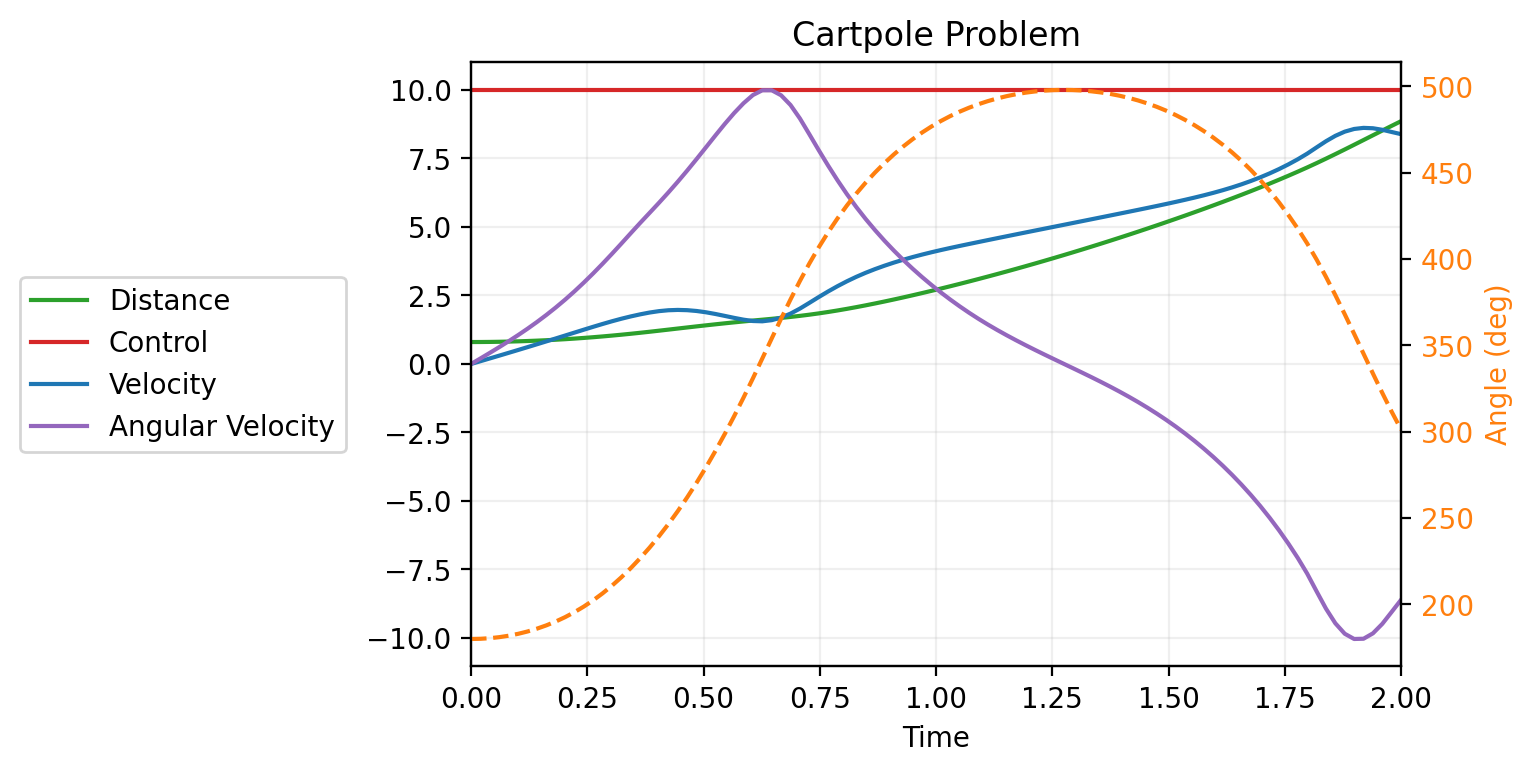

In [ ]:
from scipy.integrate import solve_ivp 

fun = cartpole_problem()

npoints = 100
fixed_force = 10.
solution = solve_ivp(lambda t, x: fun(x, fixed_force), t_span, initial_conditions, t_eval=np.linspace(*t_span, npoints))
plot_cartpole(solution.t, solution.y.T, fixed_force*np.ones((npoints, )))

# Direct Transcription via Collocation

Solve this problem by transcribing this problem using the trapezoidal collocation method. 

In [ ]:
def make_nlp(horizon, nintervals, unravel):
    nvars = nintervals + 1
    interval_duration = horizon/nintervals

    f = cartpole_problem()

    def cost(x, u):
        # IMPLEMENT: u**2
        return u**2

    def trapezoid_defect(state, next_state, control, next_control):
        # IMPLEMENT: Compute the trapezoidal defect
         return next_state - state - 0.5 * interval_duration * (f(next_state, next_control) + f(state, control))

    def trapezoid_cost(state, next_state, control, next_control):
        # IMPLEMENT: The trapezoidal quadrature to compute the integral cost
        t_ctrl = 0.5 * (cost(state, control) + cost(next_state, next_control)) * interval_duration
        return t_ctrl

    batched_cost = jax.vmap(trapezoid_cost)
    batched_defects = jax.vmap(trapezoid_defect)

    def objective(flat_variables):
        states, controls = unravel(flat_variables)
        return np.sum(batched_cost(states[:-1], states[1:], controls[:-1], controls[1:]))

    def equality_constraints(flat_variables):
        states, controls = unravel(flat_variables)
        return np.ravel(batched_defects(states[:-1], states[1:], controls[:-1], controls[1:]))

    dist = 0.8
    umax = 100
    state_bounds = onp.empty((nvars, 8))
    state_bounds[:, 0] = -2*dist
    state_bounds[:, 1] = 2*dist

    state_bounds[:, 2] = -2*onp.pi
    state_bounds[:, 3] = 2*onp.pi

    state_bounds[:, 4] = -onp.inf
    state_bounds[:, 5] = onp.inf

    state_bounds[:, 6] = -onp.inf
    state_bounds[:, 7] = onp.inf

    state_bounds[0, :] = 0
    state_bounds[-1, :] = 0
    state_bounds[-1, 0] = dist
    state_bounds[-1, 1] = dist
    state_bounds[-1, 2] = np.pi
    state_bounds[-1, 3] = np.pi

    control_bounds = onp.empty((nvars, 2))
    control_bounds[:] = [-umax, umax]

    return objective, equality_constraints, np.vstack(
        (np.reshape(state_bounds, (-1, 2)),
         control_bounds))

We provide a better-than-nothing guess on the state trajectory using a linear interpolation between $x(t_0)$ and $x(t_f)$.

In [ ]:
intervals = 20
nvars = intervals + 1

linear_interpolation = np.arange(nvars)/(nvars-1)
initial_states = np.tile(initial_conditions, (nvars, 1))
initial_states = linear_interpolation[:, np.newaxis] * initial_states
initial_variables = (initial_states, np.zeros(nvars))
flat_initial_variables, unravel = ravel_pytree(initial_variables)

Let's finally solve the problem using SLSQP:

In [ ]:
objective, equality_constraints, bounds = make_nlp(t_end, intervals, unravel)
constraints = ({'type': 'eq',
                'fun': jax.jit(equality_constraints),
                'jac': jax.jit(jax.jacrev(equality_constraints))
                })
solution = minimize(fun=jax.jit(objective),
                    x0=flat_initial_variables,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds,
                    jac=jax.jit(jax.grad(objective)))
solution.message

'Optimization terminated successfully.'

If the optimization succeeded, you should be able to verify that the last state of the trajectory matches the boundary condition.

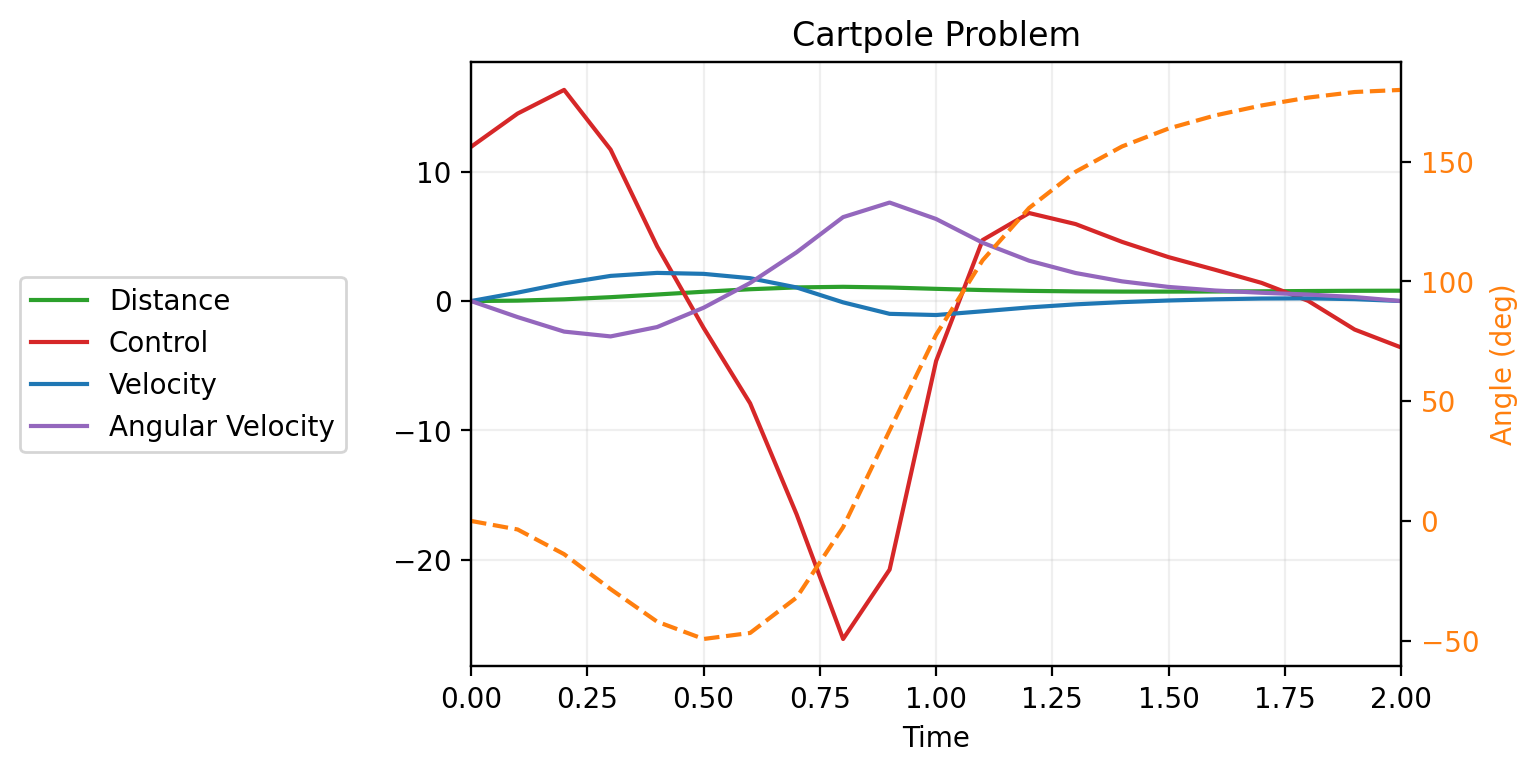

In [ ]:
states, controls = unravel(solution.x)
times = np.linspace(*t_span, nvars)
plot_cartpole(times, states, controls)